In [17]:
import pennylane as qml
import pennylane.numpy as np
import scipy.io.wavfile
import wave
import time
import math
import matplotlib.pyplot as plt

In [18]:


# Function to load a WAV file
def load_wav(filename):
    sample_rate, data = scipy.io.wavfile.read(filename)
    # If stereo, convert to mono by averaging the two channels
    if len(data.shape) == 2:
        data = data.mean(axis=1)
    return sample_rate, data

# Function to save a WAV file
def save_wav(filename, sample_rate, data):
    scipy.io.wavfile.write(filename, sample_rate, data)

# Function to convert audio samples to 8-bit
def convert_to_8bit(data):
    # Normalize data to the range of 8-bit audio [-128, 127]
    data = ((data - data.min()) / (data.max() - data.min()) * 255 - 128).astype(np.int8)
    return data

filename = 'qhack_demo7_very_short.wav'  # Specify your input file name here
sample_rate, original_data = load_wav(filename)

print("done converting wav data")

def QPAM_Encoding_Normalization(samples):
    # Normalize the array to be between 0 and 2
    normalized_arr = 2 * (samples - np.min(samples)) / (np.max(samples) - np.min(samples))

    # 2301.01595.pdf
    # • Step 1: add 1 to all amplitudes an
    # • Step 2: divide the amplitudes by 2
    # • Step 3: divide again, by the sum of all of the amplitudes
    # • Step 4: take the square root of the result

    np_data = np.array(normalized_arr)
    np_data += 1
    np_data /= 2
    sum = np.sum(np_data)
    np_data = np_data/sum

    print(np_data)
    return np_data

features = QPAM_Encoding_Normalization(original_data)
length = features.shape[0]
nb_qubits = math.ceil(np.log2(length))


print(f"number of qubits used for encoding: {nb_qubits}")


done converting wav data
[0.00012962 0.00012962 0.00012963 ... 0.00019442 0.00019431 0.00019412]
number of qubits used for encoding: 13


C:\Users\simon\AppData\Local\Temp\ipykernel_28716\4240069897.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = scipy.io.wavfile.read(filename)


encoding result: [1.09551418e-04 1.04884148e-04 9.89182168e-05 ... 9.82017005e-05
 9.54535534e-05 9.24631864e-05]
[-17993 -18773 -19771 ... -19891 -20350 -20850]
mega1707497664.807481.wav file has been created.


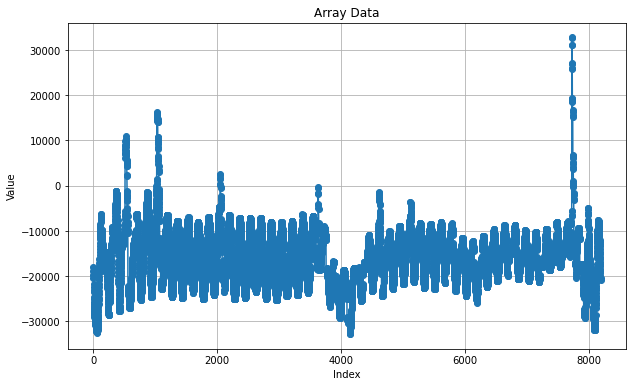

In [20]:
dev = qml.device('default.qubit', wires=nb_qubits)

phase_shifts = [0.1 for i in range(nb_qubits)]

@qml.qnode(dev)
def circuit(f=None):
    qml.AmplitudeEmbedding(features=f, wires=range(nb_qubits), pad_with=0,normalize=True)

    # Apply QFT
    qml.QFT(wires=range(nb_qubits))
    
    # Apply phase shifts to simulate pitch shifting
    for i, phase_shift in enumerate(phase_shifts):
        qml.PhaseShift(phase_shift, wires=i)
    
    # Apply inverse QFT
    qml.adjoint(qml.QFT)(wires=range(nb_qubits))


    return qml.probs(wires=range(nb_qubits))
results = circuit(features)
print(f"encoding result: {results}")
normalized_results = ((results - np.min(results)) / (np.max(results) - np.min(results))) * (32767 + 32768) - 32768

# Create a WAV file
with wave.open(f'mega{time.time()}.wav', 'w') as wav_file:
    # Set the parameters: 1 channel, 2 bytes per sample, sample rate, number of frames, compression type, compression name
    wav_file.setparams((1, 2, sample_rate, length, 'NONE', 'not compressed'))
    
    # Write the samples to the file
    quantum_samples_array = np.array(normalized_results, dtype=np.int16)
    print(quantum_samples_array)
    wav_file.writeframes(np.array(quantum_samples_array).tobytes())

print(f"mega{time.time()}.wav file has been created.")

# Create a graph to display the data
plt.figure(figsize=(10, 6))
plt.plot(normalized_results, marker='o')
plt.title("Array Data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()